In [5]:
from __future__ import print_function

%matplotlib inline

import sys
import zipfile
from dateutil.parser import parse
import json
from random import shuffle
import random
import datetime
import os

import boto3
import s3fs
import sagemaker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from datetime import timedelta
import math


from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import IntSlider, FloatSlider, Checkbox

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer

from sagemaker import image_uris


In [6]:
# set random seeds for reproducibility
np.random.seed(42)
random.seed(42)


In [7]:
sagemaker_session = sagemaker.Session()


In [8]:
s3_bucket = sagemaker.Session().default_bucket()  # replace with an existing bucket if needed
s3_bucket_prefix = (
    "deepar-retail-notebook"  # prefix used for all data stored within the bucket
)
default_bucket_prefix = sagemaker.Session().default_bucket_prefix

# If a default bucket prefix is specified, append it to the s3 path
if default_bucket_prefix:
    s3_prefix = f"{default_bucket_prefix}/{s3_bucket_prefix}"
else:
    s3_prefix = s3_bucket_prefix

role = sagemaker.get_execution_role()  # IAM role to use by SageMaker

In [9]:
region = sagemaker_session.boto_region_name

s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)

In [10]:
image_name = sagemaker.image_uris.retrieve("forecasting-deepar", region)


[05/10/25 00:50:04] INFO     Same images used for training and inference. Defaulting to image     ]8;id=234053;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=146316;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

[05/10/25 00:50:05] INFO     Ignoring unnecessary instance type: None.                            ]8;id=571858;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=91161;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

In [6]:
online_retail_df = pd.read_json('online_retail.json')
online_retail_df


,Description,Date,UnitsSold,RevenuePounds,AveragePricePerUnitPounds
0,12 pencils small tube red spotty,2009-12-01,45,29.90,0.66
1,12 pencils small tube red spotty,2009-12-02,87,61.75,0.71
2,12 pencils small tube red spotty,2009-12-03,34,23.40,0.69
3,12 pencils small tube red spotty,2009-12-04,84,55.25,0.66
4,12 pencils small tube red spotty,2009-12-05,0,0.00,0.65
...,...,...,...,...,...
104933,wood black board ant white finish,2011-12-05,23,177.13,7.70
104934,wood black board ant white finish,2011-12-06,4,31.80,7.95
104935,wood black board ant white finish,2011-12-07,70,484.50,6.92
104936,wood black board ant white finish,2011-12-08,226,1142.34,5.05


In [15]:
formatted_df = online_retail_df.rename(columns={
    'Description': 'ProductId'
})
formatted_df = formatted_df.sort_values(['Date', 'ProductId'])
formatted_df = formatted_df[['Date', 'ProductId', 'UnitsSold']].reset_index()
formatted_df['UnitsSold'] = formatted_df['UnitsSold'].astype(float)
formatted_df

,index,Date,ProductId,UnitsSold
0,0,2009-12-01,12 pencils small tube red spotty,45.0
1,739,2009-12-01,12 pencils tall tube posy,69.0
2,1478,2009-12-01,12 pencils tall tube woodland,4.0
3,2217,2009-12-01,6 ribbons rustic charm,27.0
4,2956,2009-12-01,60 teatime fairy cake cases,173.0
...,...,...,...,...
104933,104198,2011-12-09,wooden rounders garden set,0.0
104934,102720,2011-12-09,wooden school colouring set,13.0
104935,74638,2011-12-09,woodland charlotte bag,40.0
104936,75377,2011-12-09,world war 2 gliders asstd designs,49.0


In [16]:
explanatory_variables=pd.read_csv('combined_explanatory_variables.csv')
explanatory_variables

,date,gift_ideas,chained-volume-percentage-change-3-months-on-same-period-a-year-earlier,chained-volume-percentage-change-on-previous-month,chained-volume-percentage-change-on-same-month-a-year-earlier,current-prices-percentage-change-on-previous-month,current-prices-percentage-change-on-same-month-a-year-earlier,is_black_friday,is_cyber_monday,cpi,...,interest_rate,unemployment_rate,is_holiday,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday
0,2009-12-01,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4517,7.7,0.0,False,False,False,False,False,True,False
1,2009-12-02,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4532,7.7,0.0,False,False,False,False,False,False,True
2,2009-12-03,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4522,7.7,0.0,False,False,False,False,True,False,False
3,2009-12-04,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4502,7.7,0.0,True,False,False,False,False,False,False
4,2009-12-05,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4502,7.7,0.0,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,2011-12-05,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5273,8.3,0.0,False,True,False,False,False,False,False
735,2011-12-06,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5272,8.3,0.0,False,False,False,False,False,True,False
736,2011-12-07,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5264,8.3,0.0,False,False,False,False,False,False,True
737,2011-12-08,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5392,8.3,0.0,False,False,False,False,True,False,False


In [70]:
formatted_df['Date'] = pd.to_datetime(formatted_df['Date'])
explanatory_variables['date'] = pd.to_datetime(explanatory_variables['date'])

df_merged = pd.merge(formatted_df, explanatory_variables, how='left', left_on='Date', right_on='date')
df_merged = df_merged.drop(columns=['date'])
df_merged

,index,Date,ProductId,UnitsSold,gift_ideas,chained-volume-percentage-change-3-months-on-same-period-a-year-earlier,chained-volume-percentage-change-on-previous-month,chained-volume-percentage-change-on-same-month-a-year-earlier,current-prices-percentage-change-on-previous-month,current-prices-percentage-change-on-same-month-a-year-earlier,...,interest_rate,unemployment_rate,is_holiday,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday
0,0,2009-12-01,12 pencils small tube red spotty,45.0,92,11.4,-1.0,9.4,-0.1,10.9,...,0.4517,7.7,0.0,False,False,False,False,False,True,False
1,739,2009-12-01,12 pencils tall tube posy,69.0,92,11.4,-1.0,9.4,-0.1,10.9,...,0.4517,7.7,0.0,False,False,False,False,False,True,False
2,1478,2009-12-01,12 pencils tall tube woodland,4.0,92,11.4,-1.0,9.4,-0.1,10.9,...,0.4517,7.7,0.0,False,False,False,False,False,True,False
3,2217,2009-12-01,6 ribbons rustic charm,27.0,92,11.4,-1.0,9.4,-0.1,10.9,...,0.4517,7.7,0.0,False,False,False,False,False,True,False
4,2956,2009-12-01,60 teatime fairy cake cases,173.0,92,11.4,-1.0,9.4,-0.1,10.9,...,0.4517,7.7,0.0,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104933,104198,2011-12-09,wooden rounders garden set,0.0,94,8.8,-1.5,6.6,-2.0,9.4,...,0.5292,8.3,0.0,True,False,False,False,False,False,False
104934,102720,2011-12-09,wooden school colouring set,13.0,94,8.8,-1.5,6.6,-2.0,9.4,...,0.5292,8.3,0.0,True,False,False,False,False,False,False
104935,74638,2011-12-09,woodland charlotte bag,40.0,94,8.8,-1.5,6.6,-2.0,9.4,...,0.5292,8.3,0.0,True,False,False,False,False,False,False
104936,75377,2011-12-09,world war 2 gliders asstd designs,49.0,94,8.8,-1.5,6.6,-2.0,9.4,...,0.5292,8.3,0.0,True,False,False,False,False,False,False


In [17]:
formatted_df["Date"] = pd.to_datetime(formatted_df["Date"])
explanatory_variables["date"] = pd.to_datetime(explanatory_variables["date"])

# Sort explanatory_df
explanatory_variables = explanatory_variables.sort_values("date")

# Set frequency – assume daily data
prediction_length = 30
freq = "D"
train_end_date = formatted_df['Date'].max() - pd.Timedelta(days=30)

# Align explanatory variables
explanatory_variables.set_index("date", inplace=True)
dynamic_features = explanatory_variables[
    ["gift_ideas", "cpi", "cci", "interest_rate", "unemployment_rate", "chained-volume-percentage-change-3-months-on-same-period-a-year-earlier", "chained-volume-percentage-change-on-previous-month", "chained-volume-percentage-change-on-same-month-a-year-earlier", 
    "current-prices-percentage-change-on-previous-month", "current-prices-percentage-change-on-same-month-a-year-earlier"]
].copy()

# Apply log1p to "gift_ideas"
dynamic_features["gift_ideas"] = np.log1p(dynamic_features["gift_ideas"])

# Fill NA if any
dynamic_features = dynamic_features.fillna(method="ffill").fillna(method="bfill")

train_series = []
test_series = []
actual_series = []

for product_id, df_group in formatted_df.groupby("ProductId"):
    df_group = df_group.sort_values("Date")

    start_date = df_group["Date"].iloc[0]
    target = df_group["UnitsSold"].tolist()
    target_log = np.log1p(target)

    train_df = df_group[df_group["Date"] <= train_end_date]
    test_df = df_group
    train_len = len(train_df)

    start_str = pd.Timestamp(start_date).strftime("%Y-%m-%d")

    feat_dynamic_real = dynamic_features.loc[df_group["Date"]].T.values.tolist()

    if train_len >= prediction_length:
        # Training record
        train_series.append({
            "start": start_str,
            "target": target_log[:train_len],
            "feat_dynamic_real": [feat[:train_len] for feat in feat_dynamic_real],
            "item_id": str(product_id)
        })

        # Testing record (full context for prediction)
        test_series.append({
            "start": start_str,
            "target": target_log[:train_len],
            "feat_dynamic_real": [feat[:train_len] for feat in feat_dynamic_real],
            "item_id": str(product_id)
        })

        # Actual future values (for evaluation only)
        actual_series.append({
            "item_id": str(product_id),
            "actual": target_log[train_len:train_len + prediction_length]
        })


/tmp/ipykernel_14300/2924493403.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dynamic_features = dynamic_features.fillna(method="ffill").fillna(method="bfill")


In [18]:
import json

def convert_numpy(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    return obj

# Save train_series
with open("train.json", "w") as f:
    for record in train_series:
        record_cleaned = json.loads(json.dumps(record, default=convert_numpy))
        f.write(json.dumps(record_cleaned) + "\n")

# Save test_series
with open("test.json", "w") as f:
    for record in test_series:
        record_cleaned = json.loads(json.dumps(record, default=convert_numpy))
        f.write(json.dumps(record_cleaned) + "\n")


with open("actual.json", "w") as f:
    for record in future_data:
        f.write(json.dumps(record) + "\n")







In [19]:
df = pd.read_json("test.json", lines=True)
df

,start,target,feat_dynamic_real,item_id
0,2009-12-01,"[3.828641396489095, 4.477336814478206, 3.55534...","[[4.532599493153255, 4.532599493153255, 4.5325...",12 pencils small tube red spotty
1,2009-12-01,"[4.2484952420493585, 4.477336814478206, 4.7621...","[[4.532599493153255, 4.532599493153255, 4.5325...",12 pencils tall tube posy
2,2009-12-01,"[1.6094379124341, 3.091042453358315, 2.6390573...","[[4.532599493153255, 4.532599493153255, 4.5325...",12 pencils tall tube woodland
3,2009-12-01,"[3.3322045101752042, 2.079441541679835, 1.3862...","[[4.532599493153255, 4.532599493153255, 4.5325...",6 ribbons rustic charm
4,2009-12-01,"[5.159055299214529, 5.075173815233827, 5.30826...","[[4.532599493153255, 4.532599493153255, 4.5325...",60 teatime fairy cake cases
...,...,...,...,...
137,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[4.532599493153255, 4.532599493153255, 4.5325...",wooden rounders garden set
138,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[4.532599493153255, 4.532599493153255, 4.5325...",wooden school colouring set
139,2009-12-01,"[3.555348061489413, 3.044522437723423, 2.39789...","[[4.532599493153255, 4.532599493153255, 4.5325...",woodland charlotte bag
140,2009-12-01,"[3.891820298110626, 6.077642243349034, 4.04305...","[[4.532599493153255, 4.532599493153255, 4.5325...",world war 2 gliders asstd designs


In [13]:
from sagemaker import image_uris, Session
from sagemaker.estimator import Estimator
import sagemaker
from sagemaker.inputs import TrainingInput


role = sagemaker.get_execution_role()
s3 = boto3.client('s3')
bucket = s3_bucket
prefix = 'deepar-retail2'

s3.upload_file('train.json', bucket, f'{prefix}/train/train.json')
s3.upload_file('test.json', bucket, f'{prefix}/test/test.json')

s3_train_path = f's3://{bucket}/{prefix}/train/'
s3_test_path = f's3://{bucket}/{prefix}/test/'

image_uri = image_uris.retrieve(framework='forecasting-deepar', region=sagemaker_session.boto_region_name)

estimator = Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.m5.large',
    output_path=f's3://{bucket}/{prefix}/output/',
    sagemaker_session=sagemaker_session
) 

# Set hyperparameters
estimator.set_hyperparameters(
    time_freq='D',
    context_length=365,
    prediction_length=30,
    epochs=100,
    early_stopping_patience=5,
    mini_batch_size=64,
    learning_rate=5e-4,
    num_layers=3,
    num_cells=80,
    likelihood="student-t",
    test_quantiles="[0.1, 0.5, 0.9]"
)

# Launch training job
estimator.fit({
    "train": TrainingInput(s3_train_path, content_type="json"),
    "test": TrainingInput(s3_test_path, content_type="json")
})

[05/09/25 22:33:54] INFO     Same images used for training and inference. Defaulting to image     ]8;id=234053;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=146316;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=571858;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=91161;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=243962;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=529903;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=735392;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=571412;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1042\1042]8;;\
                             forecasting-deepar-2025-05-09-22-33-54-786                                            

2025-05-09 22:33:55 Starting - Starting the training job...
2025-05-09 22:34:30 Downloading - Downloading input data......
2025-05-09 22:35:05 Downloading - Downloading the training image..................
2025-05-09 22:38:22 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[05/09/2025 22:38:28 INFO 140561103341376] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likel

In [3]:
sm = boto3.client('sagemaker')

training_job_name = "forecasting-deepar-2025-05-09-22-33-54-786"
response = sm.describe_training_job(TrainingJobName=training_job_name)
model_artifact = response["ModelArtifacts"]["S3ModelArtifacts"]
print(model_artifact)

s3://sagemaker-us-east-2-153999390800/deepar-retail2/output/forecasting-deepar-2025-05-09-22-33-54-786/output/model.tar.gz


In [4]:
from sagemaker.model import Model
image_uri = image_uris.retrieve("forecasting-deepar", region=region)

model = Model(
    image_uri=image_uri,
    model_data=model_artifact,
    role=role,
    sagemaker_session=sagemaker_session
)

predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│    1 from sagemaker.model import Model                                                           │
│ ❱  2 image_uri = image_uris.retrieve("forecasting-deepar", region=region)                        │
│    3                                                                                             │
│    4 model = Model(                                                                              │
│    5 │   image_uri=image_uri,                                                                    │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'region' is not defined

In [25]:
import json
import numpy as np
from numpy import array

# Load test context data (used as input)
with open("test.json") as f:
    test_data = [json.loads(line) for line in f]

# Load true future values (not used in prediction)
with open("actual.json") as f:
    actual_data = [json.loads(line) for line in f]

# Sanity check: match by index/item_id
assert len(test_data) == len(actual_data)

# Prediction settings
prediction_length = 30
mape_list = []
smape_list = []

for i in range(len(test_data)):
    context_series = test_data[i]
    future_series = actual_data[i]

    # Construct input for SageMaker endpoint
    input_series = {
        "start": context_series["start"],
        "target": context_series["target"]
    }

    payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

    # Predict
    serialized_input = json.dumps(payload).encode("utf-8")
    response = predictor.predict(
        serialized_input,
        initial_args={"ContentType": "application/json"}
    )
    result = json.loads(response.decode("utf-8"))

    log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
    forecast = np.expm1(log_forecast)
    forecast = np.clip(forecast, 0, None)

    # Actual values
    log_actual = np.array(future_series["actual"])
    actual = np.expm1(log_actual)
    predicted = array(forecast)

    # MAPE
    mask = actual != 0
    if np.any(mask):
        mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
        mape_list.append(mape)

        # SMAPE
        denominator = (np.abs(actual[mask]) + np.abs(predicted[mask])) / 2
        smape = np.mean(np.abs(predicted[mask] - actual[mask]) / denominator) * 100
        smape_list.append(smape)

       
# Summary
print(f"Mean MAPE: {np.mean(mape_list):.2f}%")
print(f"Mean SMAPE: {np.mean(smape_list):.2f}%")

print(f"MAPE range: {min(mape_list):.2f}% to {max(mape_list):.2f}%")
print(f"sMAPE range: {min(smape_list):.2f}% to {max(smape_list):.2f}%")


Mean MAPE: 72.44%
Mean SMAPE: 88.19%
MAPE range: 60.35% to 97.86%
sMAPE range: 77.71% to 101.71%


In [27]:
max_mape_index = indices[smape_list.index(min(smape_list))]
min_mape_index = indices[mape_list.index(max(mape_list))]
print(min_mape_index)
print(max_mape_index)

1
3


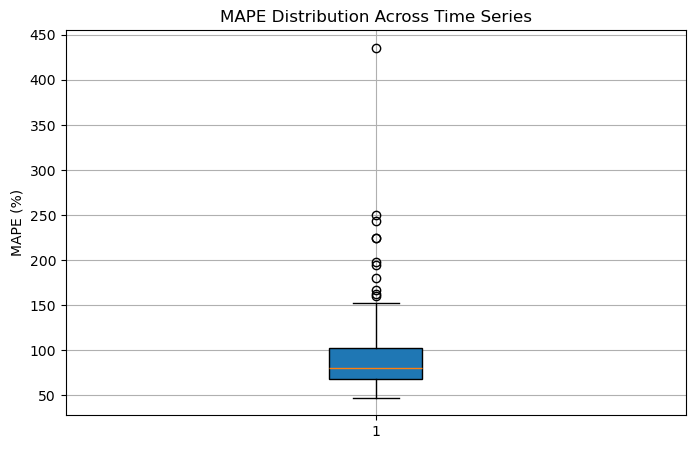

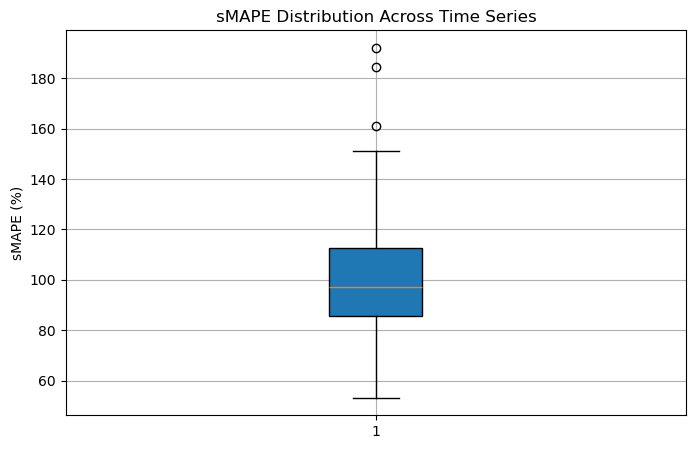

In [22]:
import matplotlib.pyplot as plt

# Create boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(mape_list, vert=True, patch_artist=True)
plt.title("MAPE Distribution Across Time Series")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.boxplot(smape_list, vert=True, patch_artist=True)
plt.title("sMAPE Distribution Across Time Series")
plt.ylabel("sMAPE (%)")
plt.grid(True)
plt.show()

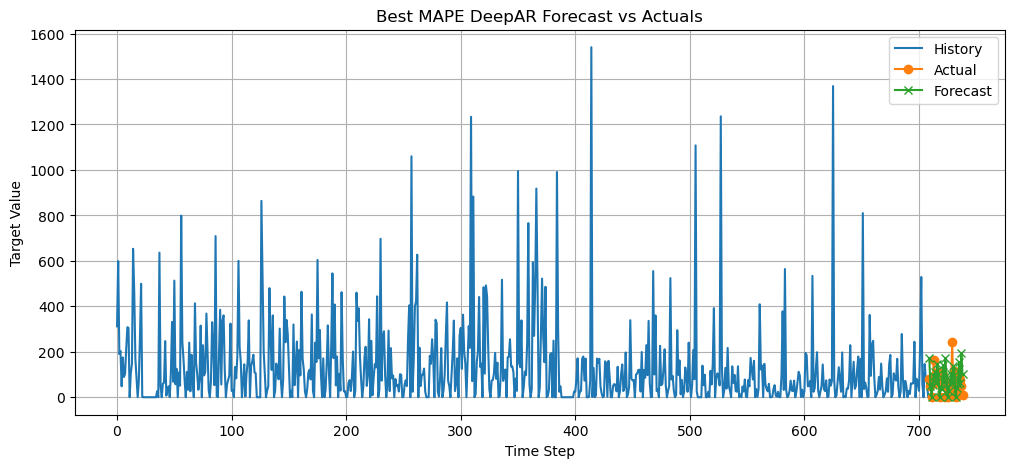

[ 78.  50.   0.  87. 164.  62.  89.  84. 109.   0.  82. 100.  99.  82.
   1.  45.   0.  15.  60.  52. 241.  29. 116.   0.  48.  42.  90.  74.
  51.   9.]
[172.23511785  50.63502789   1.11011772  55.15623315  94.26700615
 111.39379205  62.89068867 144.23297763 101.61741666   1.59146734
  40.7435012   37.65139003 141.17469137  65.37314108 172.78050632
  94.3679981    0.49857649  28.2670474   58.07888793 100.41913096
  61.20648835 138.2965309   96.70582269   2.04534466  40.63758275
  59.46242943 155.67468134  62.51085174 195.30793899 101.06451429]


In [122]:
import matplotlib.pyplot as plt
series = data[74].copy()  # or any test example
prediction_length = 30
input_series = {
        "start": series["start"],
        "target": series["target"][:-prediction_length],  # use context window only
    }
payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

serialized_input = json.dumps(payload).encode("utf-8")
response = predictor.predict(
    serialized_input,
    initial_args={"ContentType": "application/json"}
)
result = json.loads(response.decode("utf-8"))
log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
forecast = np.expm1(log_forecast)
forecast = np.clip(forecast, 0, None)

# Actual values (true future)
log_actual = series["target"][-prediction_length:]
actual = np.expm1(log_actual)

# Historical context

log_history = series["target"][:-prediction_length]
history=np.expm1(log_history)
# Plot
plt.figure(figsize=(12, 5))
plt.plot(range(len(history)), history, label="History")
plt.plot(range(len(history), len(history) + prediction_length), actual, label="Actual", marker='o')
plt.plot(range(len(history), len(history) + prediction_length), forecast, label="Forecast", marker='x')
plt.legend()
plt.title("Best MAPE DeepAR Forecast vs Actuals")
plt.xlabel("Time Step")
plt.ylabel("Target Value")
plt.grid(True)
plt.show()
print(actual)
print(forecast)

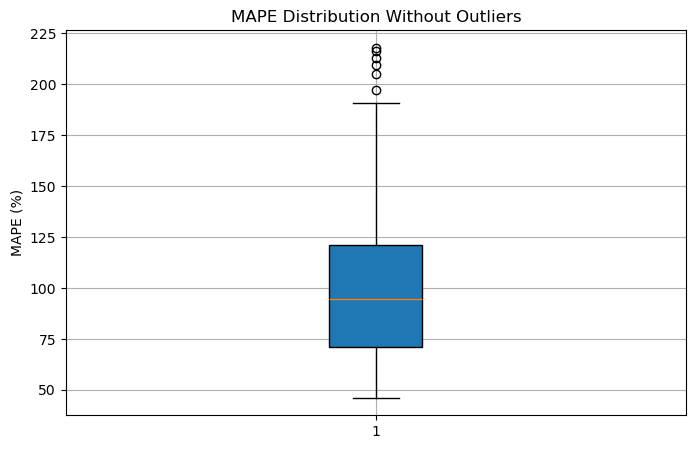

Average MAPE:  102.96202648523152


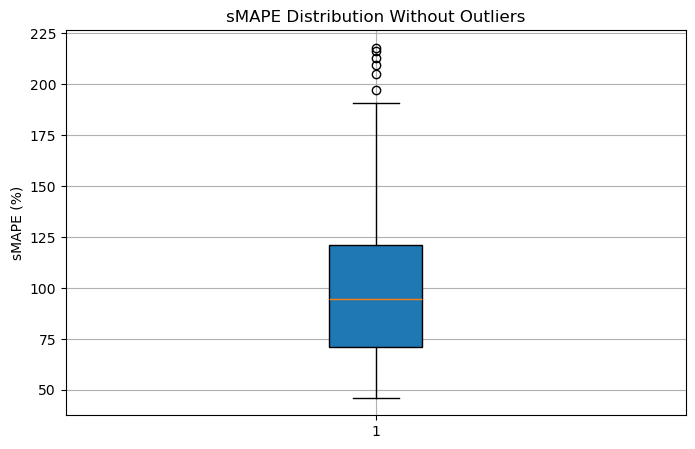

Average sMAPE:  87.76540092634613


In [123]:
mape_array = np.array(mape_list)

# Compute IQR
q1 = np.percentile(mape_array, 25)
q3 = np.percentile(mape_array, 75)
iqr = q3 - q1

# Define bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered_mape = mape_array[(mape_array >= lower_bound) & (mape_array <= upper_bound)]

# Plot boxplot without outliers
plt.figure(figsize=(8, 5))
plt.boxplot(filtered_mape, patch_artist=True)
plt.title("MAPE Distribution Without Outliers")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()

print("Average MAPE: ", np.mean(filtered_mape))


smape_array = np.array(smape_list)

# Compute IQR
q1 = np.percentile(smape_array, 25)
q3 = np.percentile(smape_array, 75)
iqr = q3 - q1

# Define bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered_smape = smape_array[(smape_array >= lower_bound) & (smape_array <= upper_bound)]

# Plot boxplot without outliers
plt.figure(figsize=(8, 5))
plt.boxplot(filtered_mape, patch_artist=True)
plt.title("sMAPE Distribution Without Outliers")
plt.ylabel("sMAPE (%)")
plt.grid(True)
plt.show()

print("Average sMAPE: ", np.mean(filtered_smape))

In [124]:
predictor.delete_endpoint()

[05/09/25 04:31:34] INFO     Deleting endpoint configuration with name:                             ]8;id=611878;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=418801;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4913\4913]8;;\
                             forecasting-deepar-2025-05-09-04-20-19-148                                            

                    INFO     Deleting endpoint with name:                                           ]8;id=517488;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=95325;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4903\4903]8;;\
                             forecasting-deepar-2025-05-09-04-20-19-148                                            

# Binary Predictors

In [91]:
explanatory_variables=pd.read_csv('combined_explanatory_variables.csv')
explanatory_variables

,date,gift_ideas,chained-volume-percentage-change-3-months-on-same-period-a-year-earlier,chained-volume-percentage-change-on-previous-month,chained-volume-percentage-change-on-same-month-a-year-earlier,current-prices-percentage-change-on-previous-month,current-prices-percentage-change-on-same-month-a-year-earlier,is_black_friday,is_cyber_monday,cpi,...,interest_rate,unemployment_rate,is_holiday,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday
0,2009-12-01,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4517,7.7,0.0,False,False,False,False,False,True,False
1,2009-12-02,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4532,7.7,0.0,False,False,False,False,False,False,True
2,2009-12-03,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4522,7.7,0.0,False,False,False,False,True,False,False
3,2009-12-04,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4502,7.7,0.0,True,False,False,False,False,False,False
4,2009-12-05,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4502,7.7,0.0,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,2011-12-05,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5273,8.3,0.0,False,True,False,False,False,False,False
735,2011-12-06,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5272,8.3,0.0,False,False,False,False,False,True,False
736,2011-12-07,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5264,8.3,0.0,False,False,False,False,False,False,True
737,2011-12-08,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5392,8.3,0.0,False,False,False,False,True,False,False


In [92]:
print(explanatory_variables.columns)


Index(['date', 'gift_ideas',
       'chained-volume-percentage-change-3-months-on-same-period-a-year-earlier',
       'chained-volume-percentage-change-on-previous-month',
       'chained-volume-percentage-change-on-same-month-a-year-earlier',
       'current-prices-percentage-change-on-previous-month',
       'current-prices-percentage-change-on-same-month-a-year-earlier',
       'is_black_friday', 'is_cyber_monday', 'cpi', 'cci', 'interest_rate',
       'unemployment_rate', 'is_holiday', 'is_Friday', 'is_Monday',
       'is_Saturday', 'is_Sunday', 'is_Thursday', 'is_Tuesday',
       'is_Wednesday'],
      dtype='object')


In [93]:
formatted_df["Date"] = pd.to_datetime(formatted_df["Date"])
explanatory_variables["date"] = pd.to_datetime(explanatory_variables["date"])

# Sort and index
explanatory_variables = explanatory_variables.sort_values("date")
explanatory_variables.set_index("date", inplace=True)

# Select binary explanatory variables
binary_features = ["is_black_friday", "is_cyber_monday",  "is_Monday", "is_holiday", "is_Tuesday", "is_Wednesday",
                   "is_Thursday", "is_Friday", "is_Saturday", "is_Sunday"]
dynamic_features = explanatory_variables[binary_features].astype(float)

# Fill any missing values
dynamic_features = dynamic_features.fillna(method="ffill").fillna(method="bfill")

# Set up
prediction_length = 30
freq = "D"
train_end_date = formatted_df['Date'].max() - pd.Timedelta(days=30)

# Fill NA if any
dynamic_features = dynamic_features.fillna(method="ffill").fillna(method="bfill")

train_series = []
test_series = []
actual_series = []

for product_id, df_group in formatted_df.groupby("ProductId"):
    df_group = df_group.sort_values("Date")

    start_date = df_group["Date"].iloc[0]
    target = df_group["UnitsSold"].tolist()
    target_log = np.log1p(target)

    train_df = df_group[df_group["Date"] <= train_end_date]
    test_df = df_group
    train_len = len(train_df)

    start_str = pd.Timestamp(start_date).strftime("%Y-%m-%d")

    feat_dynamic_real = dynamic_features.loc[df_group["Date"]].T.values.tolist()

    if train_len >= prediction_length:
        # Training record
        train_series.append({
            "start": start_str,
            "target": target_log[:train_len],
            "feat_dynamic_real": [feat[:train_len] for feat in feat_dynamic_real],
            "item_id": str(product_id)
        })

        # Testing record (full context for prediction)
        test_series.append({
            "start": start_str,
            "target": target_log[:train_len],
            "feat_dynamic_real": [feat[:train_len] for feat in feat_dynamic_real],
            "item_id": str(product_id)
        })

        # Actual future values (for evaluation only)
        actual_series.append({
            "item_id": str(product_id),
            "actual": target_log[train_len:train_len + prediction_length]
        })

/tmp/ipykernel_3378/2061237574.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dynamic_features = dynamic_features.fillna(method="ffill").fillna(method="bfill")


In [94]:
import json

def convert_numpy(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    return obj

# Save train_series
with open("train.json", "w") as f:
    for record in train_series:
        record_cleaned = json.loads(json.dumps(record, default=convert_numpy))
        f.write(json.dumps(record_cleaned) + "\n")

# Save test_series
with open("test.json", "w") as f:
    for record in test_series:
        record_cleaned = json.loads(json.dumps(record, default=convert_numpy))
        f.write(json.dumps(record_cleaned) + "\n")

with open("actual.json", "w") as f:
    for record in future_data:
        f.write(json.dumps(record) + "\n")

In [95]:
df = pd.read_json("test.json", lines=True)
df

,start,target,feat_dynamic_real,item_id
0,2009-12-01,"[3.828641396489095, 4.477336814478206, 3.55534...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12 pencils small tube red spotty
1,2009-12-01,"[4.2484952420493585, 4.477336814478206, 4.7621...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12 pencils tall tube posy
2,2009-12-01,"[1.6094379124341, 3.091042453358315, 2.6390573...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12 pencils tall tube woodland
3,2009-12-01,"[3.3322045101752042, 2.079441541679835, 1.3862...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",6 ribbons rustic charm
4,2009-12-01,"[5.159055299214529, 5.075173815233827, 5.30826...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",60 teatime fairy cake cases
...,...,...,...,...
137,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",wooden rounders garden set
138,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",wooden school colouring set
139,2009-12-01,"[3.555348061489413, 3.044522437723423, 2.39789...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",woodland charlotte bag
140,2009-12-01,"[3.891820298110626, 6.077642243349034, 4.04305...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",world war 2 gliders asstd designs


In [96]:
from sagemaker import image_uris, Session
from sagemaker.estimator import Estimator
import sagemaker
from sagemaker.inputs import TrainingInput


role = sagemaker.get_execution_role()
s3 = boto3.client('s3')
bucket = s3_bucket
prefix = 'deepar-retail2'

s3.upload_file('train.json', bucket, f'{prefix}/train/train.json')
s3.upload_file('test.json', bucket, f'{prefix}/test/test.json')

s3_train_path = f's3://{bucket}/{prefix}/train/'
s3_test_path = f's3://{bucket}/{prefix}/test/'

image_uri = image_uris.retrieve(framework='forecasting-deepar', region=sagemaker_session.boto_region_name)

estimator = Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.c4.2xlarge',
    output_path=f's3://{bucket}/{prefix}/output/',
    sagemaker_session=sagemaker_session
) 

# Set hyperparameters
estimator.set_hyperparameters(
    time_freq='D',
    context_length=365,
    prediction_length=30,
    epochs=100,
    early_stopping_patience=5,
    mini_batch_size=64,
    learning_rate=5e-4,
    num_layers=3,
    num_cells=80,
    likelihood="student-t",
    test_quantiles="[0.1, 0.5, 0.9]"
)

# Launch training job
estimator.fit({
    "train": TrainingInput(s3_train_path, content_type="json"),
    "test": TrainingInput(s3_test_path, content_type="json")
})

[05/09/25 03:35:56] INFO     Same images used for training and inference. Defaulting to image     ]8;id=442417;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=33326;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=529903;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=631262;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=681453;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=735392;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=617889;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=291704;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1042\1042]8;;\
                             forecasting-deepar-2025-05-09-03-35-56-441                                            

2025-05-09 03:35:58 Starting - Starting the training job...
2025-05-09 03:36:30 Downloading - Downloading input data...
2025-05-09 03:36:46 Downloading - Downloading the training image..................
2025-05-09 03:39:53 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[05/09/2025 03:40:10 INFO 140632891656000] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelih

In [98]:
sm = boto3.client('sagemaker')

endpoints = sm.list_endpoints()
for ep in endpoints['Endpoints']:
    print(ep['EndpointName'], ep['EndpointStatus'])


forecasting-deepar-2025-05-09-02-22-19-388 InService
forecasting-deepar-2025-05-08-22-30-50-836 InService
forecasting-deepar-2025-05-08-16-35-12-509 InService
forecasting-deepar-2025-05-08-04-51-38-026 InService
forecasting-deepar-2025-05-08-02-02-30-684 InService
forecasting-deepar-2025-05-08-01-35-52-240 InService
forecasting-deepar-2025-05-07-23-20-29-536 InService
forecasting-deepar-2025-05-07-22-49-37-820 InService


In [99]:
sm.delete_endpoint(EndpointName='forecasting-deepar-2025-05-07-22-49-37-820')


{'ResponseMetadata': {'RequestId': 'a93b0203-fa36-45a8-894f-c94d94b240e9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'a93b0203-fa36-45a8-894f-c94d94b240e9',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Fri, 09 May 2025 03:51:53 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [100]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"
)

[05/09/25 03:51:55] INFO     Creating model with name: forecasting-deepar-2025-05-09-03-51-55-179   ]8;id=967096;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=396922;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name                                     ]8;id=659176;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=648564;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#5937\5937]8;;\
                             forecasting-deepar-2025-05-09-03-51-55-179                                            

[05/09/25 03:51:56] INFO     Creating endpoint with name forecasting-deepar-2025-05-09-03-51-55-179 ]8;id=201629;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=738797;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4759\4759]8;;\

-------------!

In [118]:
import json
import numpy as np
from numpy import array

# Load test context data (used as input)
with open("test.json") as f:
    test_data = [json.loads(line) for line in f]

# Load true future values (not used in prediction)
with open("actual.json") as f:
    actual_data = [json.loads(line) for line in f]

# Sanity check: match by index/item_id
assert len(test_data) == len(actual_data)

# Prediction settings
prediction_length = 30
mape_list = []
smape_list = []

for i in range(len(test_data)):
    context_series = test_data[i]
    future_series = actual_data[i]

    # Construct input for SageMaker endpoint
    input_series = {
        "start": context_series["start"],
        "target": context_series["target"]
    }

    payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

    # Predict
    serialized_input = json.dumps(payload).encode("utf-8")
    response = predictor.predict(
        serialized_input,
        initial_args={"ContentType": "application/json"}
    )
    result = json.loads(response.decode("utf-8"))

    log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
    forecast = np.expm1(log_forecast)
    forecast = np.clip(forecast, 0, None)

    # Actual values
    log_actual = np.array(future_series["actual"])
    actual = np.expm1(log_actual)
    predicted = array(forecast)

    # MAPE
    mask = actual != 0
    if np.any(mask):
        mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
        mape_list.append(mape)

        # SMAPE
        denominator = (np.abs(actual[mask]) + np.abs(predicted[mask])) / 2
        smape = np.mean(np.abs(predicted[mask] - actual[mask]) / denominator) * 100
        smape_list.append(smape)

       
# Summary
print(f"Mean MAPE: {np.mean(mape_list):.2f}%")
print(f"Mean SMAPE: {np.mean(smape_list):.2f}%")

print(f"MAPE range: {min(mape_list):.2f}% to {max(mape_list):.2f}%")


Mean MAPE: 122.66%
Mean SMAPE: 90.10%
MAPE range: 47.63% to 552.43%


In [102]:
max_mape_index = indices[mape_list.index(min(mape_list))]
min_mape_index = indices[mape_list.index(max(mape_list))]
print(min_mape_index)
print(max_mape_index)

74
100


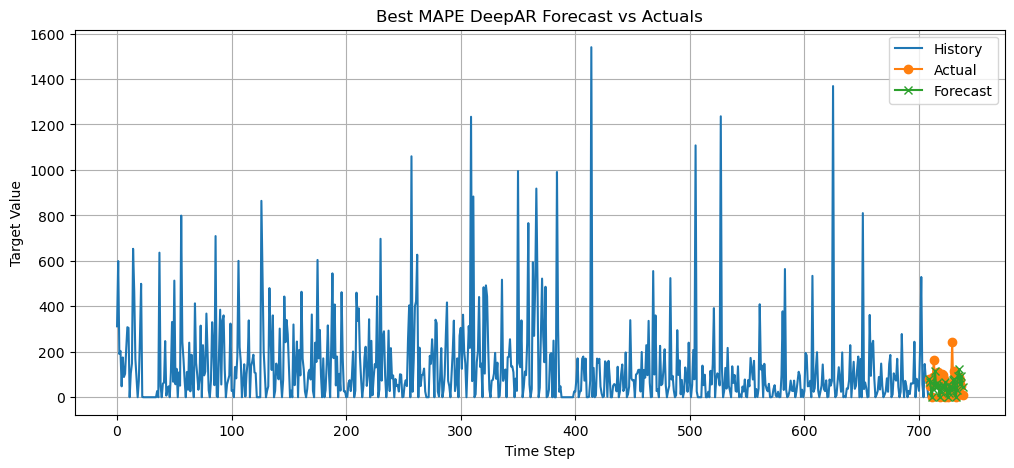

[ 78.  50.   0.  87. 164.  62.  89.  84. 109.   0.  82. 100.  99.  82.
   1.  45.   0.  15.  60.  52. 241.  29. 116.   0.  48.  42.  90.  74.
  51.   9.]
[ 78.97448676  67.37971379   0.38429715  34.7949375   54.0644803
 116.67865976  43.93349064  62.33894865  47.92141125   0.28397554
  21.04791607  47.09565467  52.37113871  45.24195843  65.79547647
  34.60034292   0.3140608   20.1610942   42.83415856  32.83628433
  46.95372085  74.13771172  80.22332761   0.71271545  30.91743488
  92.83919111 122.04680973  59.12427153  91.3971694   46.53523265]


In [103]:
import matplotlib.pyplot as plt
series = data[74].copy()  # or any test example
prediction_length = 30
input_series = {
        "start": series["start"],
        "target": series["target"][:-prediction_length],  # use context window only
    }
payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

serialized_input = json.dumps(payload).encode("utf-8")
response = predictor.predict(
    serialized_input,
    initial_args={"ContentType": "application/json"}
)
result = json.loads(response.decode("utf-8"))
log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
forecast = np.expm1(log_forecast)
forecast = np.clip(forecast, 0, None)

# Actual values (true future)
log_actual = series["target"][-prediction_length:]
actual = np.expm1(log_actual)

# Historical context

log_history = series["target"][:-prediction_length]
history=np.expm1(log_history)
# Plot
plt.figure(figsize=(12, 5))
plt.plot(range(len(history)), history, label="History")
plt.plot(range(len(history), len(history) + prediction_length), actual, label="Actual", marker='o')
plt.plot(range(len(history), len(history) + prediction_length), forecast, label="Forecast", marker='x')
plt.legend()
plt.title("Best MAPE DeepAR Forecast vs Actuals")
plt.xlabel("Time Step")
plt.ylabel("Target Value")
plt.grid(True)
plt.show()
print(actual)
print(forecast)

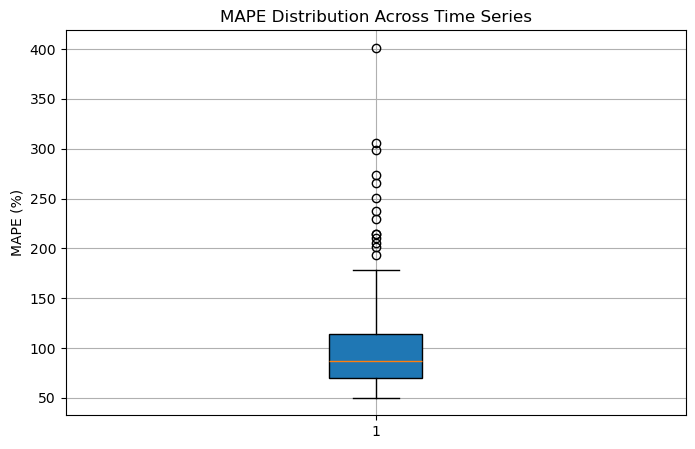

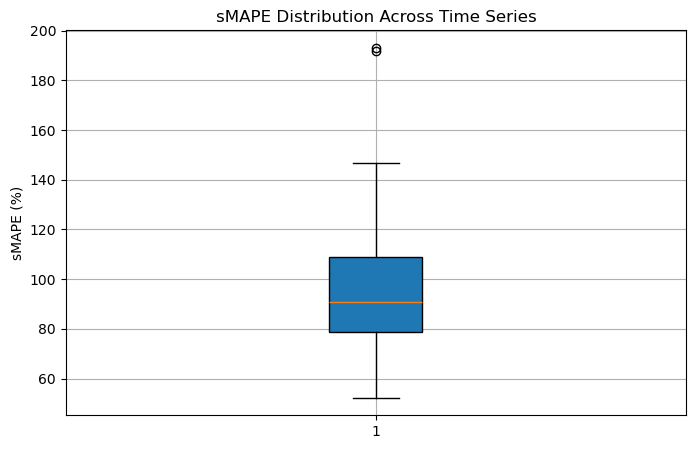

In [104]:
import matplotlib.pyplot as plt

# Create boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(mape_list, vert=True, patch_artist=True)
plt.title("MAPE Distribution Across Time Series")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.boxplot(smape_list, vert=True, patch_artist=True)
plt.title("sMAPE Distribution Across Time Series")
plt.ylabel("sMAPE (%)")
plt.grid(True)
plt.show()

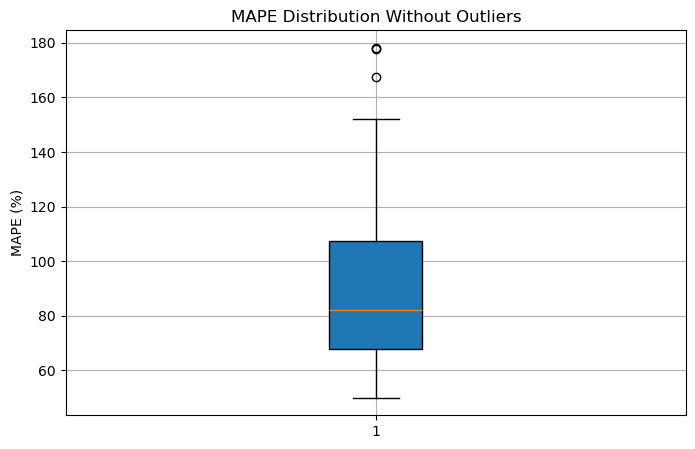

Average MAPE:  89.07369573681396


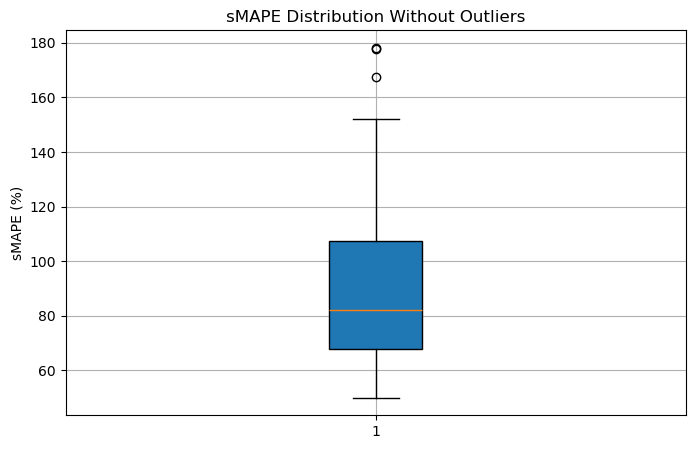

Average sMAPE:  93.33578709026284


In [105]:
mape_array = np.array(mape_list)

# Compute IQR
q1 = np.percentile(mape_array, 25)
q3 = np.percentile(mape_array, 75)
iqr = q3 - q1

# Define bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered_mape = mape_array[(mape_array >= lower_bound) & (mape_array <= upper_bound)]

# Plot boxplot without outliers
plt.figure(figsize=(8, 5))
plt.boxplot(filtered_mape, patch_artist=True)
plt.title("MAPE Distribution Without Outliers")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()

print("Average MAPE: ", np.mean(filtered_mape))


smape_array = np.array(smape_list)

# Compute IQR
q1 = np.percentile(smape_array, 25)
q3 = np.percentile(smape_array, 75)
iqr = q3 - q1

# Define bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered_smape = smape_array[(smape_array >= lower_bound) & (smape_array <= upper_bound)]

# Plot boxplot without outliers
plt.figure(figsize=(8, 5))
plt.boxplot(filtered_mape, patch_artist=True)
plt.title("sMAPE Distribution Without Outliers")
plt.ylabel("sMAPE (%)")
plt.grid(True)
plt.show()

print("Average sMAPE: ", np.mean(filtered_smape))

In [106]:
predictor.delete_endpoint()


[05/09/25 04:03:35] INFO     Deleting endpoint configuration with name:                             ]8;id=303445;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=83667;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4913\4913]8;;\
                             forecasting-deepar-2025-05-09-03-51-55-179                                            

                    INFO     Deleting endpoint with name:                                           ]8;id=291476;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=475435;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4903\4903]8;;\
                             forecasting-deepar-2025-05-09-03-51-55-179                                            

# Combined Explanatory

In [10]:
explanatory_variables=pd.read_csv('combined_explanatory_variables.csv')
explanatory_variables

,date,gift_ideas,chained-volume-percentage-change-3-months-on-same-period-a-year-earlier,chained-volume-percentage-change-on-previous-month,chained-volume-percentage-change-on-same-month-a-year-earlier,current-prices-percentage-change-on-previous-month,current-prices-percentage-change-on-same-month-a-year-earlier,is_black_friday,is_cyber_monday,cpi,...,interest_rate,unemployment_rate,is_holiday,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday
0,2009-12-01,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4517,7.7,0.0,False,False,False,False,False,True,False
1,2009-12-02,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4532,7.7,0.0,False,False,False,False,False,False,True
2,2009-12-03,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4522,7.7,0.0,False,False,False,False,True,False,False
3,2009-12-04,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4502,7.7,0.0,True,False,False,False,False,False,False
4,2009-12-05,92,11.4,-1.0,9.4,-0.1,10.9,False,False,90.7,...,0.4502,7.7,0.0,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,2011-12-05,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5273,8.3,0.0,False,True,False,False,False,False,False
735,2011-12-06,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5272,8.3,0.0,False,False,False,False,False,True,False
736,2011-12-07,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5264,8.3,0.0,False,False,False,False,False,False,True
737,2011-12-08,94,8.8,-1.5,6.6,-2.0,9.4,False,False,95.2,...,0.5392,8.3,0.0,False,False,False,False,True,False,False


In [11]:


formatted_df["Date"] = pd.to_datetime(formatted_df["Date"])
explanatory_variables["date"] = pd.to_datetime(explanatory_variables["date"])

# Sort and index
explanatory_variables = explanatory_variables.sort_values("date")
explanatory_variables.set_index("date", inplace=True)

# Select binary explanatory variables
all_features = [
    "gift_ideas", "cpi", "cci", "interest_rate", "unemployment_rate", "chained-volume-percentage-change-3-months-on-same-period-a-year-earlier", "chained-volume-percentage-change-on-previous-month", "chained-volume-percentage-change-on-same-month-a-year-earlier", 
    "current-prices-percentage-change-on-previous-month", "current-prices-percentage-change-on-same-month-a-year-earlier", "is_black_friday", "is_cyber_monday",  "is_Monday", "is_holiday", "is_Tuesday", "is_Wednesday", "is_Thursday", "is_Friday", "is_Saturday", 
    "is_Sunday"
]

dynamic_features = explanatory_variables[all_features].astype(float).copy()

dynamic_features["gift_ideas"] = np.log1p(dynamic_features["gift_ideas"])

# Fill any missing values
dynamic_features = dynamic_features.fillna(method="ffill").fillna(method="bfill")

prediction_length = 30
freq = "D"
train_end_date = formatted_df['Date'].max() - pd.Timedelta(days=30)

# Fill NA if any
dynamic_features = dynamic_features.fillna(method="ffill").fillna(method="bfill")

train_series = []
test_series = []
actual_series = []

for product_id, df_group in formatted_df.groupby("ProductId"):
    df_group = df_group.sort_values("Date")

    start_date = df_group["Date"].iloc[0]
    target = df_group["UnitsSold"].tolist()
    target_log = np.log1p(target)

    train_df = df_group[df_group["Date"] <= train_end_date]
    test_df = df_group
    train_len = len(train_df)

    start_str = pd.Timestamp(start_date).strftime("%Y-%m-%d")

    feat_dynamic_real = dynamic_features.loc[df_group["Date"]].T.values.tolist()

    if train_len >= prediction_length:
        # Training record
        train_series.append({
            "start": start_str,
            "target": target_log[:train_len],
            "feat_dynamic_real": [feat[:train_len] for feat in feat_dynamic_real],
            "item_id": str(product_id)
        })

        # Testing record (full context for prediction)
        test_series.append({
            "start": start_str,
            "target": target_log[:train_len],
            "feat_dynamic_real": [feat[:train_len] for feat in feat_dynamic_real],
            "item_id": str(product_id)
        })

        # Actual future values (for evaluation only)
        actual_series.append({
            "item_id": str(product_id),
            "actual": target_log[train_len:train_len + prediction_length]
        })

/tmp/ipykernel_7035/2494629114.py:20: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  dynamic_features = dynamic_features.fillna(method="ffill").fillna(method="bfill")


In [13]:
import json

def convert_numpy(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, (np.integer, np.floating)):
        return obj.item()
    return obj

# Save train_series
with open("train.json", "w") as f:
    for record in train_series:
        record_cleaned = json.loads(json.dumps(record, default=convert_numpy))
        f.write(json.dumps(record_cleaned) + "\n")

# Save test_series
with open("test.json", "w") as f:
    for record in test_series:
        record_cleaned = json.loads(json.dumps(record, default=convert_numpy))
        f.write(json.dumps(record_cleaned) + "\n")

with open("actual.json") as f:
    actual_data = [json.loads(line) for line in f]

In [14]:
df = pd.read_json("test.json", lines=True)
df

,start,target,feat_dynamic_real,item_id
0,2009-12-01,"[3.828641396489095, 4.477336814478206, 3.55534...","[[4.532599493153255, 4.532599493153255, 4.5325...",12 pencils small tube red spotty
1,2009-12-01,"[4.2484952420493585, 4.477336814478206, 4.7621...","[[4.532599493153255, 4.532599493153255, 4.5325...",12 pencils tall tube posy
2,2009-12-01,"[1.6094379124341, 3.091042453358315, 2.6390573...","[[4.532599493153255, 4.532599493153255, 4.5325...",12 pencils tall tube woodland
3,2009-12-01,"[3.3322045101752042, 2.079441541679835, 1.3862...","[[4.532599493153255, 4.532599493153255, 4.5325...",6 ribbons rustic charm
4,2009-12-01,"[5.159055299214529, 5.075173815233827, 5.30826...","[[4.532599493153255, 4.532599493153255, 4.5325...",60 teatime fairy cake cases
...,...,...,...,...
137,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[4.532599493153255, 4.532599493153255, 4.5325...",wooden rounders garden set
138,2009-12-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[[4.532599493153255, 4.532599493153255, 4.5325...",wooden school colouring set
139,2009-12-01,"[3.555348061489413, 3.044522437723423, 2.39789...","[[4.532599493153255, 4.532599493153255, 4.5325...",woodland charlotte bag
140,2009-12-01,"[3.891820298110626, 6.077642243349034, 4.04305...","[[4.532599493153255, 4.532599493153255, 4.5325...",world war 2 gliders asstd designs


In [15]:
from sagemaker import image_uris, Session
from sagemaker.estimator import Estimator
import sagemaker
from sagemaker.inputs import TrainingInput


role = sagemaker.get_execution_role()
s3 = boto3.client('s3')
bucket = s3_bucket
prefix = 'deepar-retail2'

s3.upload_file('train.json', bucket, f'{prefix}/train/train.json')
s3.upload_file('test.json', bucket, f'{prefix}/test/test.json')

s3_train_path = f's3://{bucket}/{prefix}/train/'
s3_test_path = f's3://{bucket}/{prefix}/test/'

image_uri = image_uris.retrieve(framework='forecasting-deepar', region=sagemaker_session.boto_region_name)

estimator = Estimator(
    image_uri=image_uri,
    role=role,
    instance_count=1,
    instance_type='ml.c4.2xlarge',
    output_path=f's3://{bucket}/{prefix}/output/',
    sagemaker_session=sagemaker_session
) 

# Set hyperparameters
estimator.set_hyperparameters(
    time_freq='D',
    context_length=365,
    prediction_length=30,
    epochs=100,
    early_stopping_patience=5,
    mini_batch_size=64,
    learning_rate=5e-4,
    num_layers=3,
    num_cells=80,
    likelihood="student-t",
    test_quantiles="[0.1, 0.5, 0.9]"
)

# Launch training job
estimator.fit({
    "train": TrainingInput(s3_train_path, content_type="json"),
    "test": TrainingInput(s3_test_path, content_type="json")
})

[05/09/25 04:50:40] INFO     Same images used for training and inference. Defaulting to image     ]8;id=98246;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=229258;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=588508;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=208496;file:///opt/conda/lib/python3.12/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     SageMaker Python SDK will collect telemetry to help us better  ]8;id=471029;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py\telemetry_logging.py]8;;\:]8;id=617889;file:///opt/conda/lib/python3.12/site-packages/sagemaker/telemetry/telemetry_logging.py#91\91]8;;\
                             understand our user's needs, diagnose issues, and deliver                             
                             additional features.                                                                  
                             To opt out of telemetry, please disable via TelemetryOptOut                           
                             parameter in SDK defaults config. For more information, refer                         
                             to                                                                                    
                             https://sagemaker.readthedocs.io/en/stable/overview.html#confi                        
                             guring-and-using-defaults-with-the-sagemaker-python-sdk.                              

                    INFO     Creating training-job with name:                                       ]8;id=167414;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=732052;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#1042\1042]8;;\
                             forecasting-deepar-2025-05-09-04-50-40-135                                            

2025-05-09 04:50:42 Starting - Starting the training job...
2025-05-09 04:51:15 Downloading - Downloading input data...
2025-05-09 04:51:30 Downloading - Downloading the training image..................
2025-05-09 04:54:32 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Running custom environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[05/09/2025 04:54:51 INFO 139827324888896] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'_kvstore': 'auto', '_num_gpus': 'auto', '_num_kv_servers': 'auto', '_tuning_objective_metric': '', 'cardinality': 'auto', 'dropout_rate': '0.10', 'early_stopping_patience': '', 'embedding_dimension': '10', 'learning_rate': '0.001', 'likelih

In [16]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large"
)

[05/09/25 05:04:20] INFO     Creating model with name: forecasting-deepar-2025-05-09-05-04-20-409   ]8;id=800581;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=352944;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4094\4094]8;;\

[05/09/25 05:04:21] INFO     Creating endpoint-config with name                                     ]8;id=888662;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=360663;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#5937\5937]8;;\
                             forecasting-deepar-2025-05-09-05-04-20-409                                            

                    INFO     Creating endpoint with name forecasting-deepar-2025-05-09-05-04-20-409 ]8;id=481741;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=562275;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4759\4759]8;;\

-------------!

In [17]:
import json
import numpy as np
from numpy import array

# Load test context data (used as input)
with open("test.json") as f:
    test_data = [json.loads(line) for line in f]

# Load true future values (not used in prediction)
with open("actual.json") as f:
    actual_data = [json.loads(line) for line in f]

# Sanity check: match by index/item_id
assert len(test_data) == len(actual_data)

# Prediction settings
prediction_length = 30
mape_list = []
smape_list = []

for i in range(len(test_data)):
    context_series = test_data[i]
    future_series = actual_data[i]

    # Construct input for SageMaker endpoint
    input_series = {
        "start": context_series["start"],
        "target": context_series["target"]
    }

    payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

    # Predict
    serialized_input = json.dumps(payload).encode("utf-8")
    response = predictor.predict(
        serialized_input,
        initial_args={"ContentType": "application/json"}
    )
    result = json.loads(response.decode("utf-8"))

    log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
    forecast = np.expm1(log_forecast)
    forecast = np.clip(forecast, 0, None)

    # Actual values
    log_actual = np.array(future_series["actual"])
    actual = np.expm1(log_actual)
    predicted = array(forecast)

    # MAPE
    mask = actual != 0
    if np.any(mask):
        mape = np.mean(np.abs((actual[mask] - predicted[mask]) / actual[mask])) * 100
        mape_list.append(mape)

        # SMAPE
        denominator = (np.abs(actual[mask]) + np.abs(predicted[mask])) / 2
        smape = np.mean(np.abs(predicted[mask] - actual[mask]) / denominator) * 100
        smape_list.append(smape)

# Summary
print(f"Mean MAPE: {np.mean(mape_list):.2f}%")
print(f"Mean SMAPE: {np.mean(smape_list):.2f}%")

print(f"MAPE range: {min(mape_list):.2f}% to {max(mape_list):.2f}%")


Mean MAPE: 120.09%
Mean SMAPE: 89.11%
MAPE range: 46.89% to 525.99%


In [18]:
max_mape_index = indices[mape_list.index(min(mape_list))]
min_mape_index = indices[mape_list.index(max(mape_list))]
print(min_mape_index)
print(max_mape_index)

74
127


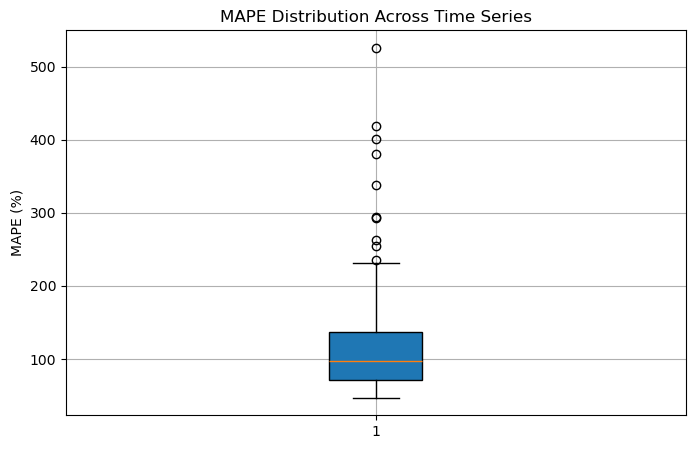

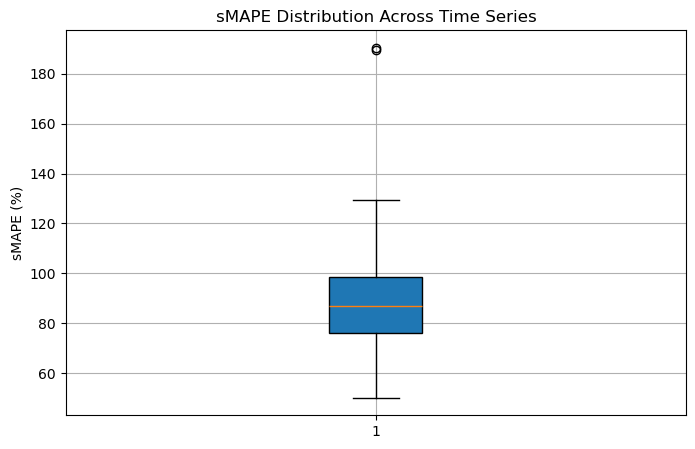

In [19]:
import matplotlib.pyplot as plt

# Create boxplot
plt.figure(figsize=(8, 5))
plt.boxplot(mape_list, vert=True, patch_artist=True)
plt.title("MAPE Distribution Across Time Series")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.boxplot(smape_list, vert=True, patch_artist=True)
plt.title("sMAPE Distribution Across Time Series")
plt.ylabel("sMAPE (%)")
plt.grid(True)
plt.show()

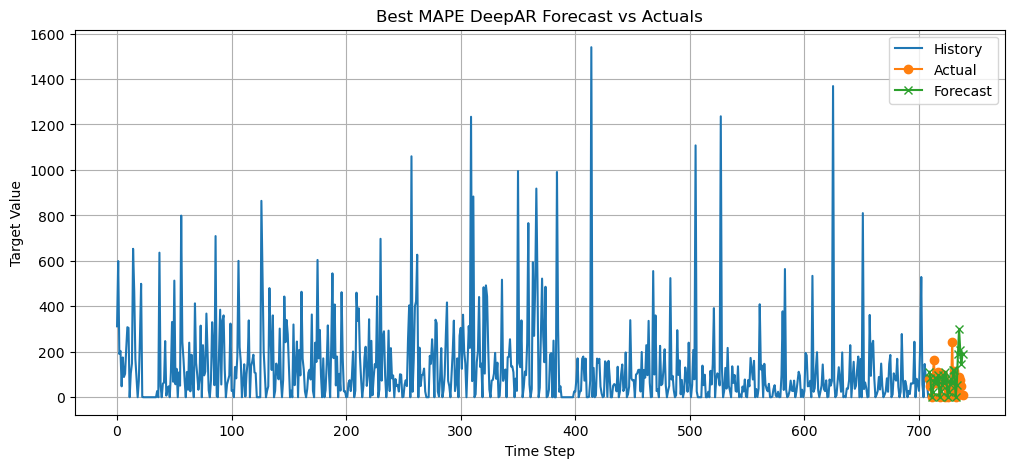

[ 78.  50.   0.  87. 164.  62.  89.  84. 109.   0.  82. 100.  99.  82.
   1.  45.   0.  15.  60.  52. 241.  29. 116.   0.  48.  42.  90.  74.
  51.   9.]
[1.12012619e+02 8.60537335e+01 4.78161376e-02 2.34404482e+01
 6.68177888e+01 8.31585919e+01 6.07784272e+01 8.04162784e+01
 9.76640907e+01 2.89458671e-02 2.51806068e+01 5.40362352e+01
 9.72392354e+01 6.28482948e+01 1.10668183e+02 8.21671685e+01
 0.00000000e+00 2.33233899e+01 5.70637230e+01 8.19834021e+01
 6.22560974e+01 1.18800873e+02 1.20471221e+02 8.60782117e-01
 5.40647691e+01 1.89349306e+02 3.01181437e+02 2.08245808e+02
 1.45855627e+02 1.90834184e+02]


In [20]:
import matplotlib.pyplot as plt
series = data[74].copy()  # or any test example
prediction_length = 30
input_series = {
        "start": series["start"],
        "target": series["target"][:-prediction_length],  # use context window only
    }
payload = {
        "instances": [input_series],
        "configuration": {
            "num_samples": 100,
            "output_types": ["mean", "quantiles", "samples"],
            "quantiles": ["0.5"]
        }
    }

serialized_input = json.dumps(payload).encode("utf-8")
response = predictor.predict(
    serialized_input,
    initial_args={"ContentType": "application/json"}
)
result = json.loads(response.decode("utf-8"))
log_forecast = np.array(result["predictions"][0]["quantiles"]["0.5"])
forecast = np.expm1(log_forecast)
forecast = np.clip(forecast, 0, None)

# Actual values (true future)
log_actual = series["target"][-prediction_length:]
actual = np.expm1(log_actual)

# Historical context

log_history = series["target"][:-prediction_length]
history=np.expm1(log_history)
# Plot
plt.figure(figsize=(12, 5))
plt.plot(range(len(history)), history, label="History")
plt.plot(range(len(history), len(history) + prediction_length), actual, label="Actual", marker='o')
plt.plot(range(len(history), len(history) + prediction_length), forecast, label="Forecast", marker='x')
plt.legend()
plt.title("Best MAPE DeepAR Forecast vs Actuals")
plt.xlabel("Time Step")
plt.ylabel("Target Value")
plt.grid(True)
plt.show()
print(actual)
print(forecast)

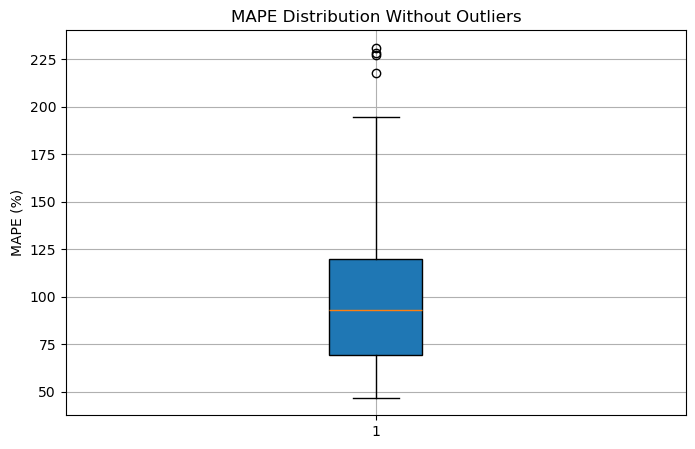

Average MAPE:  103.25867768189751


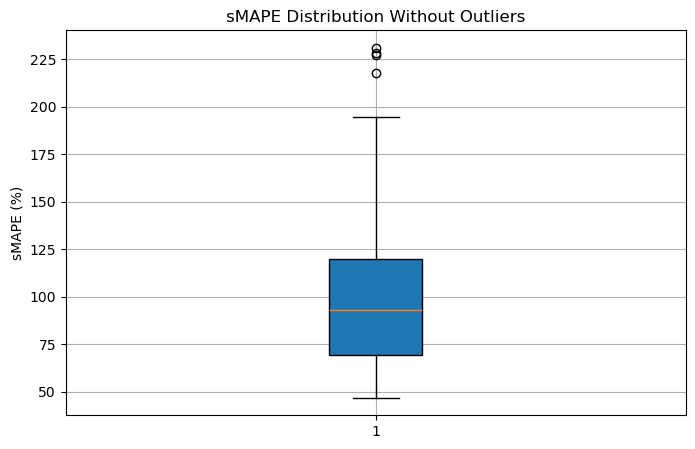

Average sMAPE:  87.65944940961607


In [21]:
mape_array = np.array(mape_list)

# Compute IQR
q1 = np.percentile(mape_array, 25)
q3 = np.percentile(mape_array, 75)
iqr = q3 - q1

# Define bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered_mape = mape_array[(mape_array >= lower_bound) & (mape_array <= upper_bound)]

# Plot boxplot without outliers
plt.figure(figsize=(8, 5))
plt.boxplot(filtered_mape, patch_artist=True)
plt.title("MAPE Distribution Without Outliers")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.show()

print("Average MAPE: ", np.mean(filtered_mape))


smape_array = np.array(smape_list)

# Compute IQR
q1 = np.percentile(smape_array, 25)
q3 = np.percentile(smape_array, 75)
iqr = q3 - q1

# Define bounds
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out outliers
filtered_smape = smape_array[(smape_array >= lower_bound) & (smape_array <= upper_bound)]

# Plot boxplot without outliers
plt.figure(figsize=(8, 5))
plt.boxplot(filtered_mape, patch_artist=True)
plt.title("sMAPE Distribution Without Outliers")
plt.ylabel("sMAPE (%)")
plt.grid(True)
plt.show()

print("Average sMAPE: ", np.mean(filtered_smape))

In [22]:
predictor.delete_endpoint()

[05/09/25 05:16:40] INFO     Deleting endpoint configuration with name:                             ]8;id=307419;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=869693;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4913\4913]8;;\
                             forecasting-deepar-2025-05-09-05-04-20-409                                            

                    INFO     Deleting endpoint with name:                                           ]8;id=605397;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=201629;file:///opt/conda/lib/python3.12/site-packages/sagemaker/session.py#4903\4903]8;;\
                             forecasting-deepar-2025-05-09-05-04-20-409                                            